In [1]:
import torch

In [30]:
import pandas as pd 
import copy
import csv
import functools
import glob
import os

import collections
from collections import namedtuple

import SimpleITK as sitk
import numpy as np

import torch
import torch.cuda
from torch.utils.data import Dataset

#from util.disk import getCache
#from util.util import XyzTuple, xyz2irc
#from util.logconf import logging

# Fight cancer: LUNA Grand Challenge
The project will take three-dimensional CT scans of human torsos as input and produce as output the location of suspected malignant tumors, if any exist.

At a high level, our model will be comprised of repeated convolutional layers followed by a resolution-reducing downsampling layer will still make up the majority of our model. 3D data will be used as inputs to the model. This is conceptually similar to the 2D image data that was used in the <ins>convolutions.ipynb</ins> file for the birds versus airplanes problem, but we will not be able to rely on all of the 2D-specific tools available in the PyTorch ecosystem.

For the birds versus airplanes problem, off-the-shelf dataset and did little data manipulation before feeding the data into a model for classification. This is not the case for this project.


## Workflow
Our approach to detecting cancerous nodules will have five rough steps: data loading, segmentation, grouping, classification, and nodule analysis and diagnosis.

1. Load our raw CT scan data into a form usable by PyTorch.
2. Identify the voxels of potential tumors in the lungs using PyTorch to implement a technique known as segmentation. This is roughly akin to producing a heatmap of areas that should be fed into our classifier in step 3. This will allow us to focus on potential tumors inside the lungs and ignore huge swaths of uninteresting anatomy (a person can’t have lung cancer in the stomach, for example).
3. Group "interesting" voxels into lumps: that is, candidate nodules. Each nodule can be located by the index, row, and column of its center point. This is done to ultimately present a simple, constrained problem to the final classifier. Here, we will find the rough center of each hotspot on our heatmap.
4. Classify candidate nodules as actual nodules or non-nodules using 3D convolution.
5. Diagnose the patient using the combined per-nodule classifications. Similar to the nodule classifier in the previous step, we will attempt to determine whether the nodule is <strong>benign</strong> or <strong>malignant</strong> based on imaging data alone.  We will take a simple maximum of the per-tumor malignancy predictions, as only one tumor needs to be malignant for a patient to have cancer. 

A nodule —a small mass in the lung— can turn out to be benign or a malignant tumor (also referred to as cancer). From a radiological perspective, a nodule is really similar to other lumps that have a wide variety of causes: infection, inflammation, blood-supply issues, malformed blood vessels, and diseases other than tumors.

We are using the LUNA Grand Challenge data to train our model. The LUNA data contains CT scans, as well as human-annotated outputs for classification and grouping.
## Raw CT data files
Our CT data comes in two files: 
- a .mhd file containing metadata header information
- a .raw file containing the raw bytes that make up the 3D array

Each file’s name starts with a unique identifier called the series UID (the name comes from the Digital Imaging and Communications in Medicine [DICOM] nomenclature) for the CT scan in question. For example, for series UID 1.2.3, there would be two files: 1.2.3.mhd and 1.2.3.raw.


Expect to get some coordinate information, an indication of whether the coordinate is a nodule, and a unique identifier for the CT scan. BTW, a nodule in the <strong>class</strong> column can be either malignant or benign.

LUNA annotations <ins>candidates.csv</ins> contain the CT series, the nodule candidate’s position, and a flag indicating if the candidate is actually a nodule or not.


In [31]:
candidates = pd.read_csv('../LUNA/candidates.csv')
print('Number of lines in the file')
print(len(candidates))

print('Number of cases this not an actual nodule')
print(len(candidates[candidates['class'] == 0]))


print('Number of cases this an actual nodule (either malignant or benign)')
print(len(candidates[candidates['class'] == 1]))

Number of lines in the file
551065
Number of cases this not an actual nodule
549714
Number of cases this an actual nodule (either malignant or benign)
1351


In [32]:
candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0


The annotations.csv file contains information about some of the candidates that have been flagged as nodules. We are interested in the <strong>diameter_mm</strong> information in particular.

In [33]:
annotations = pd.read_csv('../LUNA/annotations.csv')
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


Statistics of nodule diameter
count    1186.000000
mean        8.306527
std         4.762033
min         3.253443
25%         5.107177
50%         6.433600
75%         9.696301
max        32.270030
Name: diameter_mm, dtype: float64


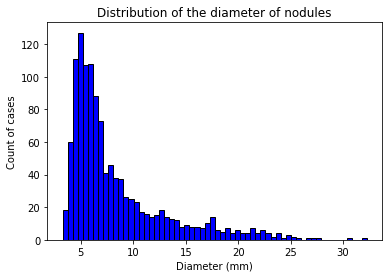

In [34]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(annotations['diameter_mm'], color = 'blue', edgecolor = 'black',
         bins = int(60))

# Add labels
plt.title('Distribution of the diameter of nodules')
plt.xlabel('Diameter (mm)')
plt.ylabel('Count of cases')
print('Statistics of nodule diameter')
print(annotations['diameter_mm'].describe())

We’ll use a named tuple that is defined at the top of the file to hold the information for each nodule.
- <strong>isNodule_bool</strong>: This will contain the nodules status. This is what we will be training the model to classify. This is the label.
- <strong>diameter_mm</strong>: Used to get a good spread in training, since large and small nodules will not have the same features. 
- <strong>series_uid</strong>: Used to locate the correct CT scan.
- <strong>center_xyz</strong>: To find the candidate in the larger CT.

In [35]:
from collections import namedtuple
        # ... line 27
CandidateInfoTuple = namedtuple('CandidateInfoTuple',
'isNodule_bool, diameter_mm, series_uid, center_xyz',
)


In [36]:
#@functools.lru_cache(1)
#def getCandidateInfoList(requireOnDisk_bool=True):
    # We construct a set with all series_uids that are present on disk.
    # This will let us use the data, even if we haven't downloaded all of
    # the subsets yet.
mhd_list = glob.glob('../LUNA/subset0/*.mhd')

#extract the UIDS from the subsets
presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

Speeding up our data pipeline by carefully applying in- memory or on-disk caching can result in some pretty impressive gains in training speed.
The <strong>requireOnDisk_bool</strong> variable which is included in the python script is a parameter that helps detecting which LUNA series UIDs are actually present and ready to be loaded from disk, and we’ll use that information to limit which entries we use from the CSV files we’re about to parse.

In [37]:
diameter_dict = {}
with open('../LUNA/annotations.csv', "r") as f:
    for row in list(csv.reader(f))[1:]:
        series_uid = row[0]
        annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
        annotationDiameter_mm = float(row[4])
        diameter_dict.setdefault(series_uid, []).append(
          (annotationCenter_xyz, annotationDiameter_mm))

Build a full list of candidates using the information in the candidates.csv file.

In [1]:
cd ../../LUNA

'/Users/egads1/Desktop/pytorch_projects/3D_Cancer_Detection'

In [38]:
requireOnDisk_bool = True
candidateInfo_list = []
with open('../LUNA/candidates.csv', "r") as f:
    for row in list(csv.reader(f))[1:]:
        series_uid = row[0]
        if series_uid not in presentOnDisk_set and requireOnDisk_bool: #<1>
            continue
   
        
        isNodule_bool = bool(int(row[4]))
        candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

        candidateDiameter_mm = 0.0
        
        for annotation_tup in diameter_dict.get(series_uid, []):
            
            annotationCenter_xyz, annotationDiameter_mm = annotation_tup
            for i in range(3):
                delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                if delta_mm > annotationDiameter_mm / 4: #<2>
                    break
            else:
                candidateDiameter_mm = annotationDiameter_mm
                break
                
                
        candidateInfo_list.append(CandidateInfoTuple(
                isNodule_bool,
                candidateDiameter_mm,
                series_uid,
                candidateCenter_xyz,
            ))
candidateInfo_list.sort(reverse=True) #<3>

1. If the series UID selected from the candidates.csv file is not present in the <strong>presentOnDisk_set</strong>, then skip that iteration. Currently, for this notebok only subset0 is used, therefore there are lot of excess UIDs from the candidates file.
2. To explain the rationale behind this condition statement, let's assume that the nodule has a circular shape. The  <strong>annotationDiameter_mm</strong> is divided by 2 to derive the radius, and by 2 to make sure that the two nodule center points not be too far apart relative to the size of the nodule. If the two coordinates are close enough to consider them the same nodule. (This results in a bounding-box check, not a true distance check) If no match is found, the nodule is treated as having a 0.0 diameter.
3. This means we have all of the actual nodule samples starting with the largest first, followed by all of the non-nodule samples (which don’t have nodule size information).

## Loading CT scans
The nodule annotation information acts like a map to the interesting parts of our raw data. In order to follow that map to our data of interest, we need to load the data into an addressable form.

In [14]:
mhd_path = glob.glob('../LUNA/subset*/*.mhd'.format(series_uid))[0]
ct_mhd = sitk.ReadImage(mhd_path)
ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
ct_a.clip(-1000, 1000, ct_a) #<1>
hu_a = ct_a

In [15]:
hu_a.shape

(733, 512, 512)

<strong>ct_a</strong> is a three-dimensional array. All three dimensions are spatial, and the single intensity channel is implicit. In a PyTorch tensor, the channel information is represented as a fourth dimension with size 1.
### Hounsfield Units
CT scan voxels are expressed in Hounsfield units(HU; https://en.wikipedia.org/wiki/Hounsfield_scale), which are odd units; air is –1,000 HU (close enough to 0 g/cc [grams per cubic centimeter] for our purposes), water is 0 HU (1 g/cc), and bone is at least +1,000 HU (2–3 g/cc).

1. For our purposes, every- thing outside of the patient should be air, so we discard that field-of-view information by setting a lower bound of the values to –1,000 HU. Similarly, the exact densities of bones, metal implants, and so on are not relevant to our use case, so we cap density at roughly 2 g/cc (1,000 HU) even though that’s not biologically accurate in most cases.

### Locating a nodule using the patient coordinate system
DL models typically need fixed-size inputs, due to having a fixed number of input neurons. We need to be able to produce a fixed-size array containing the candidate so that we can use it as input to our classifier. The model will be trained using a crop of the CT scan that has a candidate nicely centered.


We transform our coordinates from the millimeter-based coordinate system (X,Y,Z) they’re expressed in, to the voxel-address-based coordinate system (Index,Row,Column) used to take array slices from our CT scan data. Note that the patient coordinate system is measured in millimeters and has an arbitrarily posi- tioned origin that does not correspond to the origin of the CT voxel array

### Converting between millimeters and voxel addresses
## Utils


To go from voxel indices to coordinates, we need to follow these four steps in order:
1. Flip the coordinates from IRC to CRI, to align with XYZ.
2. Scale the indices with the voxel sizes.
3. Matrix-multiply with the directions matrix, using @ in Python.
4. Add the offset for the origin.

To go back from XYZ to IRC, we need to perform the inverse of each step in the reverse order.
We keep the voxel sizes in named tuples, so we convert these into arrays.


In [16]:
IrcTuple = collections.namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = collections.namedtuple('XyzTuple', ['x', 'y', 'z'])
def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1] #<a>
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    coords_xyz = (direction_a @ (idx * vxSize_a)) + origin_a #<b>
    return XyzTuple(*coords_xyz)

<strong>a.</strong> Swaps the order while we convert to a NumPy array <br>
<strong>b.</strong> The bottom three steps of our plan, all in one line <br>
 
###### @ operation


In [17]:
def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a #<a>
    cri_a = np.round(cri_a) #<b>
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0])) #<c>

<strong>a.</strong> Inverse of the last three steps <br>
<strong>b.</strong> Sneaks in proper rounding before converting to integers. <br>
<strong>c.</strong> Shuffles and converts to integer.

### Class CT

In [18]:
CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, diameter_mm, series_uid, center_xyz',
)

@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    # We construct a set with all series_uids that are present on disk.
    # This will let us use the data, even if we haven't downloaded all of
    # the subsets yet.
    mhd_path = glob.glob('../LUNA/subset*/*.mhd')
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

    diameter_dict = {}
    with open('../LUNA/annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])

            diameter_dict.setdefault(series_uid, []).append(
                (annotationCenter_xyz, annotationDiameter_mm),
            )

    candidateInfo_list = []
    with open('../LUNA/candidates.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

            candidateDiameter_mm = 0.0
            for annotation_tup in diameter_dict.get(series_uid, []):
                annotationCenter_xyz, annotationDiameter_mm = annotation_tup
                for i in range(3):
                    delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                    if delta_mm > annotationDiameter_mm / 4:
                        break
                else:
                    candidateDiameter_mm = annotationDiameter_mm
                    break

            candidateInfo_list.append(CandidateInfoTuple(
                isNodule_bool,
                candidateDiameter_mm,
                series_uid,
                candidateCenter_xyz,
            ))

    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list

Given the attributes under <strong>\_\_init\_\_</strong> , our CT object implementation now has all the data needed to convert a candidate center from patient coordinates to
array coordinates.

Up to 99.99% of the voxels in a CT scan of a patient with a lung nodule won’t be part of the actual nodule (or cancer, for that matter). Therefore we will extract an area around each candidate and let the model focus on one candidate at a time. That serves the purpose of reducing the scope of the problem for our problem

The <strong>getRawNodule</strong> function takes the center expressed in the patient coordinate system (X,Y,Z), just as it’s specified in the LUNA CSV data, as well as a width in voxels. It returns a cubic chunk of CT, as well as the center of the candidate converted to array coordinates.

In [19]:
class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob('../LUNA/subset*/*.mhd'.format(series_uid))[0]

        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
        # The lower bound gets rid of negative density stuff used to indicate out-of-FOV
        # The upper bound nukes any weird hotspots and clamps bone down
        ct_a.clip(-1000, 1000, ct_a)

        self.series_uid = series_uid
        self.hu_a = ct_a

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)

    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(
            center_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])
            slice_list.append(slice(start_ndx, end_ndx))

        ct_chunk = self.hu_a[tuple(slice_list)]

        return ct_chunk, center_irc

### Class LunaDataset


Each <strong>Ct</strong> instance represents hundreds of different samples that can be used to train our model or validate its effectiveness. Our <strong>LunaDataset</strong> class will normalize those samples, flattening (https://satoricyber.com/glossary/data-flattening/#:~:text=Data%20flattening%20is%20associated%20with,for%20example%2C%20tabular%20spreadsheet%20files.) each CT’s nodules into a single collection from which samples can be retrieved without regard for which Ct instance the sample originates from. 

The PyTorch API only requires that any Dataset subclasses we want to implement must provide these two function
- <strong>\_\_len\_\_<br></strong>
    That must return a single, constant value after initialization (the value ends up being cached in some use cases). Our dataset is as large as the number of samples we have. If we have N samples, then it returns a value f N.
- <strong>\_\_getitem\_\_<br></strong>
    Takes an index and returns a tuple with sample data to be used for training or validation. The rule for this method is that it must return something valid for all inputs 0 to N-1. This method takes the <strong>ndx</strong> as input, and we the output would be a four-item tuple.

In [20]:
#@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

#@functools.lru_cache(1, typed=True)
def getCt(series_uid):
    return Ct(series_uid)


class LunaDataset(Dataset):
    ###
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
                 sortby_str='random',
            ):
        self.candidateInfo_list = copy.copy(getCandidateInfoList())

        if series_uid:
            self.candidateInfo_list = [
                x for x in self.candidateInfo_list if x.series_uid == series_uid
            ]
            
    ###
    def __len__(self):
        return len(self.candidateInfo_list)
    ###
    def __getitem__(self, ndx):
        candidateInfo_tup = self.candidateInfo_list[ndx]
        width_irc = (32, 48, 48)

        candidate_a, center_irc = getCtRawCandidate(
            candidateInfo_tup.series_uid,
            candidateInfo_tup.center_xyz,
            width_irc,
        ) #<1>

        candidate_t = torch.from_numpy(candidate_a) 
        candidate_t = candidate_t.to(torch.float32)
        candidate_t = candidate_t.unsqueeze(0) #<2>

        pos_t = torch.tensor([
                not candidateInfo_tup.isNodule_bool,
                candidateInfo_tup.isNodule_bool
            ],
            dtype=torch.long,
        ) #<3>

        return (
            candidate_t,
            pos_t,
            candidateInfo_tup.series_uid,
            torch.tensor(center_irc),
        )
   
 

1. The return value candidate_a has shape (32,48,48); the axes are depth, height, and width.
2. The <strong>candidate_t</strong> variable undergoes a process; data manipulation into the proper data types and required array dimensions that will be expected by the downstream code
3. This is the classification tensor. This has two elements: nodule or non-nodule represented with 1 or 0 respectively, and since the nn.CrossEntropyLoss expects one output per class, two outputs must be rendered. 

Below we see the four items from our <strong>\_\_getitem\_\_</strong> return statement.


In [22]:
LunaDataset()[0]

(tensor([], size=(1, 32, 0, 48)),
 tensor([0, 1]),
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273',
 tensor([455, 639, 365]))

##### Caching candidate arrays with the getCtRawCandidate function
The function itself is easy. It’s a file-cache-backed (https://pypi.python.org/pypi/ diskcache) wrapper around the Ct.getRawCandidate method we saw earlier.

A wrapper function is a subroutine (another word for a function) in a software library or a computer program whose main purpose is to call a second subroutine or a system call with little or no additional computation. Wrapper functions are used to make writing computer programs easier by abstracting away the details of a subroutine's underlying implementation.

In computer programming, a subroutine is a sequence of program instructions that performs a specific task, packaged as a unit. This unit can then be used in programs wherever that particular task should be performed.

### Constructing v2 of LunaDataset


In [ ]:
class LunaDataset(Dataset):
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
                 sortby_str='random',
            ):
        self.candidateInfo_list = copy.copy(getCandidateInfoList()) #<1>

        if series_uid:
            self.candidateInfo_list = [
                x for x in self.candidateInfo_list if x.series_uid == series_uid
            ]

        #<2>
        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.candidateInfo_list = self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        elif val_stride > 0:
            del self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list

        if sortby_str == 'random':
            random.shuffle(self.candidateInfo_list)
        elif sortby_str == 'series_uid':
            self.candidateInfo_list.sort(key=lambda x: (x.series_uid, x.center_xyz))
        elif sortby_str == 'label_and_size':
            pass
        else:
            raise Exception("Unknown sort: " + repr(sortby_str))

        log.info("{!r}: {} {} samples".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
        ))

    def __len__(self):
        return len(self.candidateInfo_list)

    def __getitem__(self, ndx):
        candidateInfo_tup = self.candidateInfo_list[ndx]
        width_irc = (32, 48, 48)

        candidate_a, center_irc = getCtRawCandidate(
            candidateInfo_tup.series_uid,
            candidateInfo_tup.center_xyz,
            width_irc,
        )
        candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
        candidate_t = candidate_t.unsqueeze(0)

        pos_t = torch.tensor([
                not candidateInfo_tup.isNodule_bool,
                candidateInfo_tup.isNodule_bool
            ],
            dtype=torch.long,
        )

        return candidate_t, pos_t, candidateInfo_tup.series_uid, torch.tensor(center_irc)

1. Copies the return value so the cached copy won’t be impacted by altering self.candidateInfo_list
 
2. Deletes the validation images (every val_stride-th item in the list) from self.candidateInfo_list. We made a copy earlier so that we don’t alter the original list.
3. Creates seperate lists of negative and positive samples.
4. Randomize the order of samples being presented 

In [41]:
candidateInfo_list
positiveInfo_list = [x for x in candidateInfo_list if x[0]] 
diameter_list = [x[1] for x in positiveInfo_list]
for i in range(0, len(diameter_list), 100):
    print('{:4}  {:4.1f} mm'.format(i, diameter_list[i]))

   0  25.2 mm
 100   0.0 mm


In [42]:
positiveInfo_list

[CandidateInfoTuple(isNodule_bool=True, diameter_mm=25.23320204, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273', center_xyz=(63.4740118048, 73.9174523314, -213.736128767)),
 CandidateInfoTuple(isNodule_bool=True, diameter_mm=21.58311204, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235', center_xyz=(109.142472723, 49.6356928166, -121.183579092)),
 CandidateInfoTuple(isNodule_bool=True, diameter_mm=19.65387738, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114', center_xyz=(56.1226132601, 67.868268695, -65.6269886453)),
 CandidateInfoTuple(isNodule_bool=True, diameter_mm=18.7832325, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196', center_xyz=(-82.79150362, -21.43587141, -97.18427459)),
 CandidateInfoTuple(isNodule_bool=True, diameter_mm=17.75323185, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748', center_xyz=(94.1132711884, -15.8936132585, -20

### Training/Validation splits
- Both sets should include examples of all variations of expected inputs.
- Neither set should have samples that aren’t representative of expected inputs unless they have a specific purpose like training the model to be robust to outliers. 
- The training set shouldn’t offer unfair hints about the validation set that wouldn’t be true for real-world data (for example, including the same sample in both sets; this is known as a leak in the training set).


### Rendering the data
Data visualization is important; being able to investigate data visually can pro- vide important clues about errors or problems. We are using Jupyter Notebooks
and Matplotlib to render our data.

In [52]:
def findPositiveSamples(start_ndx=0, limit=100):
    ds = LunaDataset()

    positiveSample_list = []
    for sample_tup in ds.candidateInfo_list:
        if sample_tup.isNodule_bool:
            print(len(positiveSample_list), sample_tup)
            positiveSample_list.append(sample_tup)

        if len(positiveSample_list) >= limit:
            break

    return positiveSample_list
def showCandidate(series_uid, batch_ndx=None, **kwargs):
    ds = LunaDataset(series_uid=series_uid, **kwargs)
    pos_list = [i for i, x in enumerate(ds.candidateInfo_list) if x.isNodule_bool]

    if batch_ndx is None:
        if pos_list:
            batch_ndx = pos_list[0]
        else:
            print("Warning: no positive samples found; using first negative sample.")
            batch_ndx = 0

    ct = Ct(series_uid)
    ct_t, pos_t, series_uid, center_irc = ds[batch_ndx]
    ct_a = ct_t[0].numpy()

    fig = plt.figure(figsize=(30, 50))

    group_list = [
        [9, 11, 13],
        [15, 16, 17],
        [19, 21, 23],
    ]

    subplot = fig.add_subplot(len(group_list) + 2, 3, 1)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[int(center_irc[0])], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 2)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,int(center_irc[1])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 3)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,:,int(center_irc[2])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 4)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[ct_a.shape[0]//2], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 5)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,ct_a.shape[1]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 6)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,:,ct_a.shape[2]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    for row, index_list in enumerate(group_list):
        for col, index in enumerate(index_list):
            subplot = fig.add_subplot(len(group_list) + 2, 3, row * 3 + col + 7)
            subplot.set_title('slice {}'.format(index), fontsize=30)
            for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
                label.set_fontsize(20)
            plt.imshow(ct_a[index], clim=clim, cmap='gray')


    print(series_uid, batch_ndx, bool(pos_t[0]), pos_list)

0 CandidateInfoTuple(isNodule_bool=True, diameter_mm=25.23320204, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273', center_xyz=(63.4740118048, 73.9174523314, -213.736128767))
1 CandidateInfoTuple(isNodule_bool=True, diameter_mm=21.58311204, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235', center_xyz=(109.142472723, 49.6356928166, -121.183579092))
2 CandidateInfoTuple(isNodule_bool=True, diameter_mm=19.65387738, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114', center_xyz=(56.1226132601, 67.868268695, -65.6269886453))
3 CandidateInfoTuple(isNodule_bool=True, diameter_mm=18.7832325, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196', center_xyz=(-82.79150362, -21.43587141, -97.18427459))
4 CandidateInfoTuple(isNodule_bool=True, diameter_mm=17.75323185, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748', center_xyz=(94.1132711884, -15.8936132585, -2

IndexError: index 741 is out of bounds for axis 1 with size 512

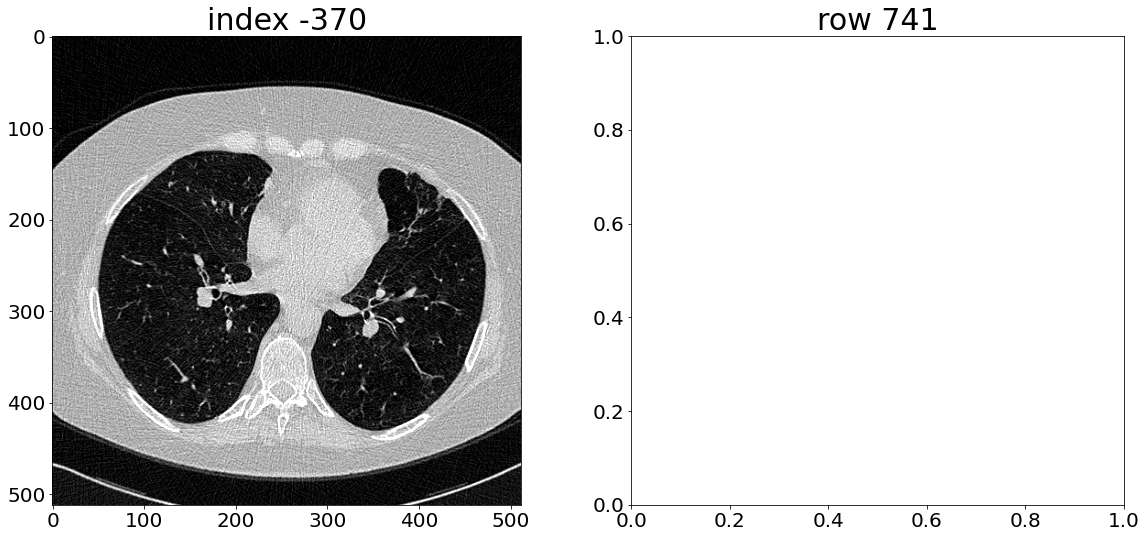

In [53]:
clim=(-1000.0, 300)
positiveSample_list = findPositiveSamples()
series_uid = positiveSample_list[11][2]
showCandidate(series_uid)